In [1]:
import torch 
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms

## ImageNet and Transfer Learning

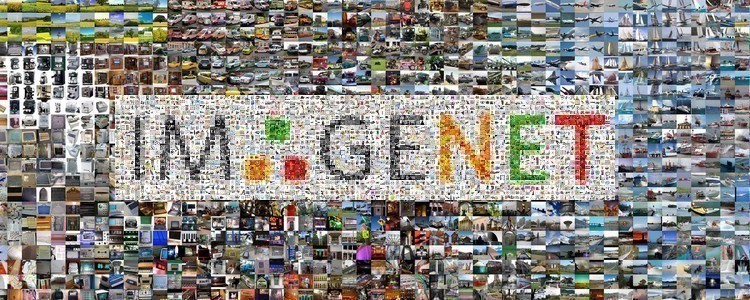

The creation of the ImageNet dataset [1] has enabled unprecedented advances in the deep learning community. This large scale dataset contains around 14 millions of images spreaded into more than 20k categories. Initially used as a benchmark to demonstrate the power of deep neural networks [2] (see ILSVRC [3]), ImageNet has become, over time, an essential component for training very deep neural networks.

In its early days, deep learning was largely limited (if we set aside the problems of computing resources) by the problem of the large number of parameters to be trained (typically millions), while the most important datasets contained only a few tens of thousands of pictures (~20k for PASCAL [4] and 60k for CIFAR10 [5]). The creation of ImageNet made it possible to demonstrate the power of deep neural networks when a large number of labelled data were available for training [2].


Nevertheless, most of real world applications does not offer practitioners volumes of data comparable to Imagenet. Thus, a new practice has emerged consisting in using the large database that is ImageNet to pre-train a neural network in order to reuse it in a future situation, less favourable in terms of volume of labelled data. In practice, the feature extractor is trained in a supervised manner on ImageNet and is then reused as a representation layer in a new task, potentially different from the ImagNet classification. This is referred as Transfer Learning, cutting-edge strategy that we explore in this notebook.

We will work with image data from the CIFAR10 dataset [5], but note that similar practrice exists in the NLP community.

You can watch this great introduction to Transfer Learning by deeplearning.ai (https://www.youtube.com/watch?v=yofjFQddwHE&feature=emb_logo)


[1] Deng, Jia, et al. "Imagenet: A large-scale hierarchical image database." 2009 IEEE conference on computer vision and pattern recognition. Ieee, 2009.

[2] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Communications of the ACM 60.6 (2017): 84-90.

[3] http://image-net.org/challenges/LSVRC/

[4] Everingham, Mark, et al. "The pascal visual object classes (voc) challenge." International journal of computer vision 88.2 (2010): 303-338.

[5] http://www.cs.toronto.edu/~kriz/cifar.html

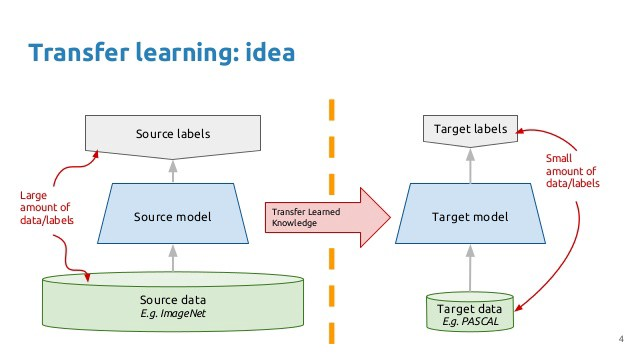

## CIFAR10

CIFAR10 [1] is a dataset with 60k images (50k for training + 10k for testing) spreaded among 10 categories (6k images per category: 5k for training + 6k for testing). Data is a RGB tensor of a low resolution image (32*32)

[1] http://www.cs.toronto.edu/~kriz/cifar.html

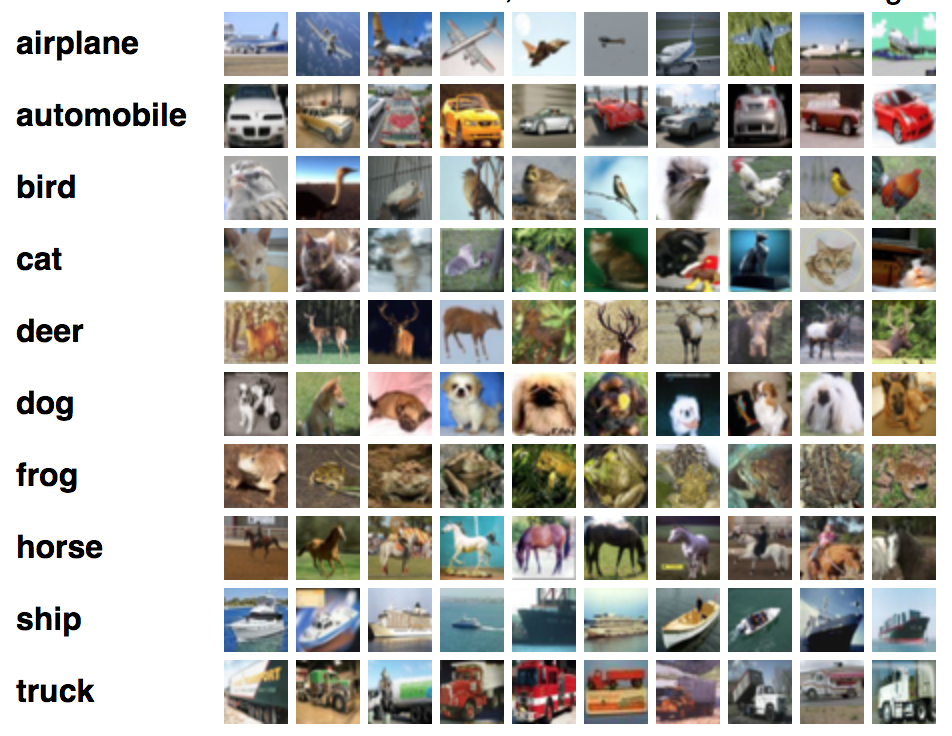

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

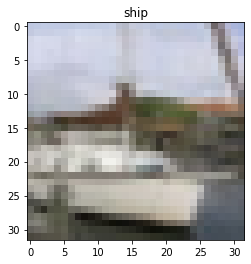

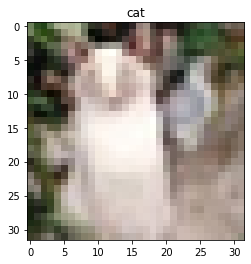

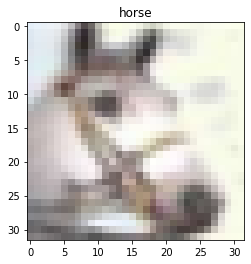

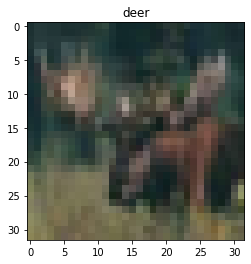

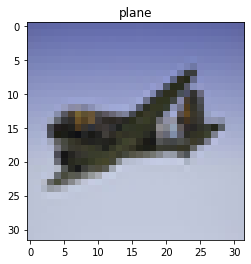

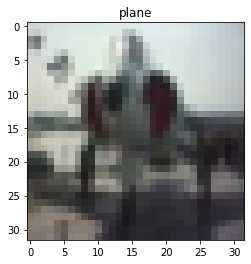

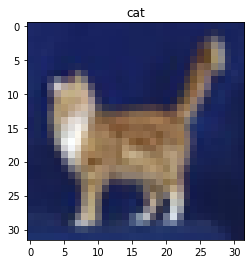

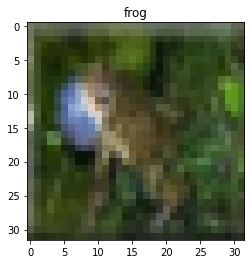

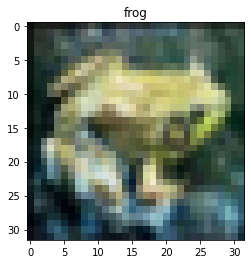

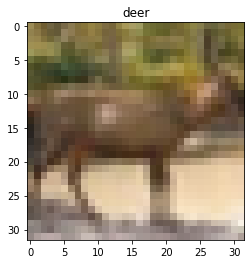

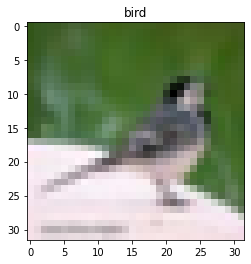

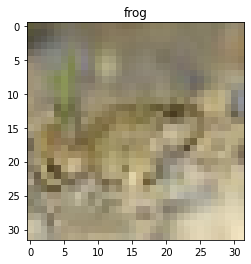

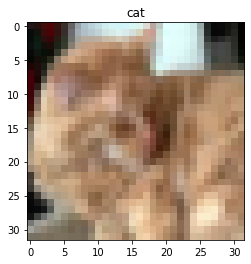

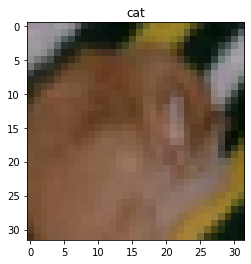

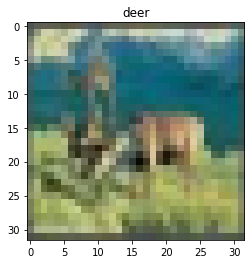

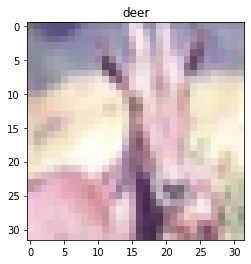

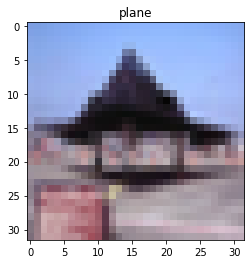

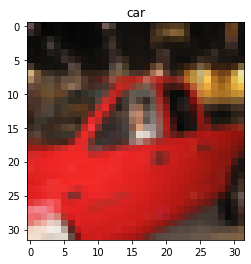

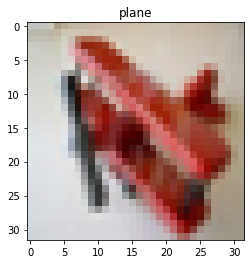

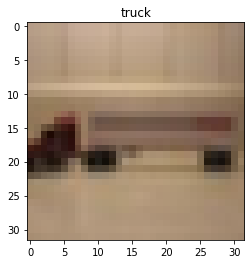

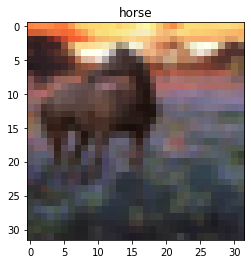

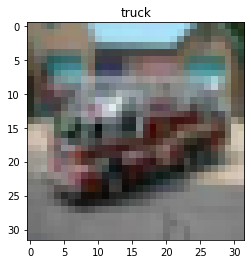

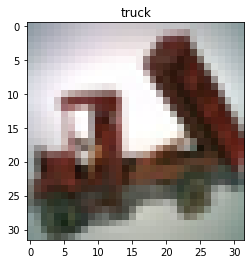

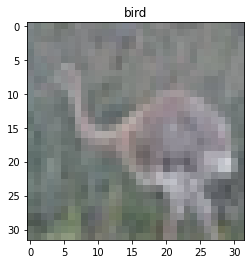

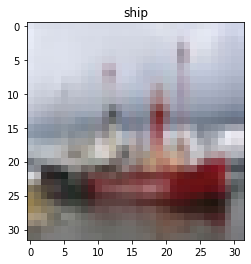

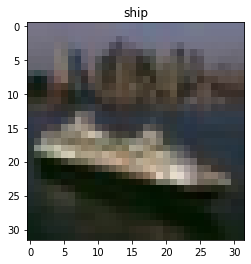

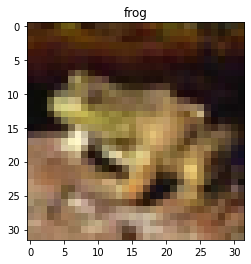

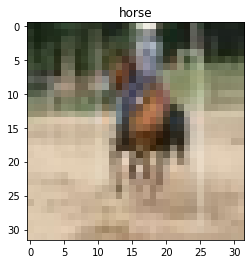

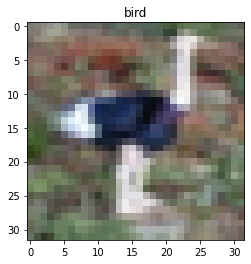

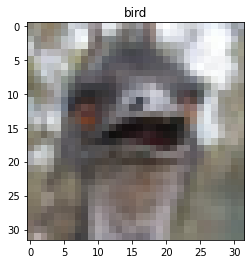

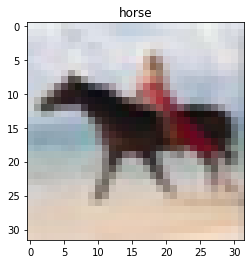

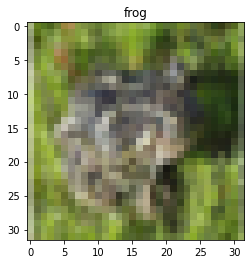

In [4]:
import matplotlib.pyplot as plt

def imshow(img):  # functions to show an image
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
for j in range(32):
    imshow(torchvision.utils.make_grid(images[j]))
    plt.title(str(classes[labels[j]]))
    plt.show()

##Training a simple ConvNet

Implement a simple ConvNet for CIFAR10 classification. You can use the ModelWrapper class of the first session.

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm 


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x): 
        # TODO: Implement the forward pass
        #1st layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        #2nd layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x) #(None,16,5,5)

        #Fully connected classifier
        x = x.view(-1,16*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        #No need to use SoftMax beause cross-entropy does that
        return x

In [6]:
class ModelWrapper:
    def __init__(self, model):
        self.model = model
        self.train_loader = None
        self.optimizer = None
        self.loss = None
        self.cuda = False

    def train_one_iter(self, x, y):
        self.optimizer.zero_grad()
        if self.cuda:
            x, y = x.cuda(), y.cuda()
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        loss.backward()
        self.optimizer.step()
    
    def train(self, training_data, sampler=None, batch_size=32, epochs=10):
        self.model.train()
        if sampler is None:
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size) 
        else: 
            pass 
            #TODO

        for _ in tqdm(range(epochs)):
            for x, y in train_loader:
                self.train_one_iter(x, y)

    def test(self, testing_data, batch_size=256):
        test_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size)
        accuracy = []
        for x, y in test_loader:
            if self.cuda:
                x, y = x.cuda(), y.cuda()
            y_hat = self.model(x)
            pred = torch.max(y_hat, 1)[1]
            accuracy.append((pred == y).float())
        return torch.cat(accuracy).mean().item()

    def compile(self, optimizer, loss=None, lr=0.001, weight_decay=0.001, cuda=True):
        self.loss = loss
        try: 
            self.optimizer = optimizer(params=self.model.parameters(), 
                                 lr=lr,
                                 weight_decay=weight_decay)
        except:
            print('Must be called after create_model()')    

        self.cuda = cuda

        if self.cuda:
            self.model = self.model.cuda() 

Train the model, this may take several minutes!

In [7]:
net = Net()
model_wrapper = ModelWrapper(net) # TODO
model_wrapper.compile(loss=nn.CrossEntropyLoss(),  # TODO
                      optimizer=torch.optim.Adam) # TODO
model_wrapper.train(trainset, epochs=10) # TODO
accuracy = model_wrapper.test(testset) # TODO

print('Accuracy is', accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy is 0.6067000031471252


See some prediction on the test set.

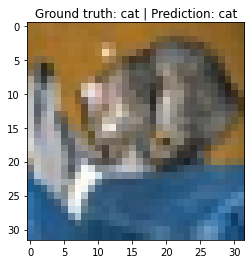

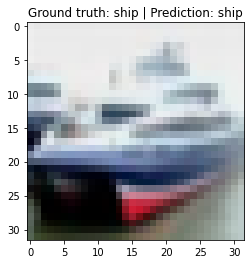

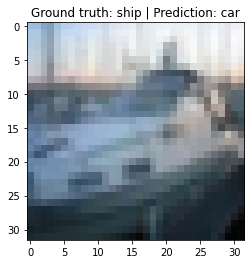

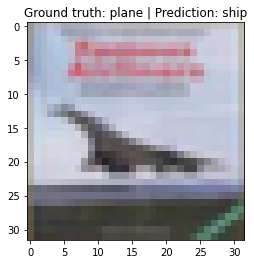

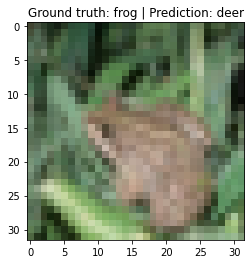

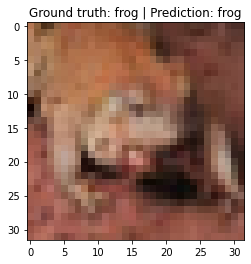

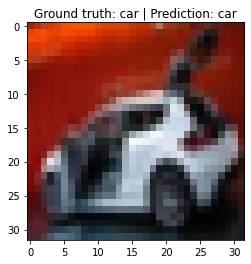

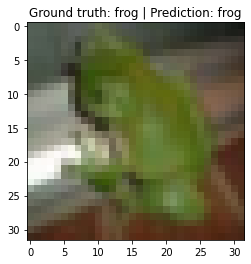

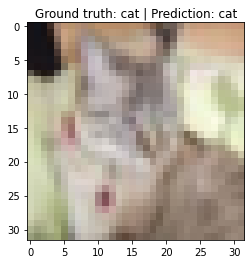

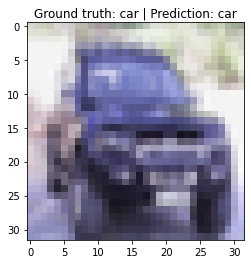

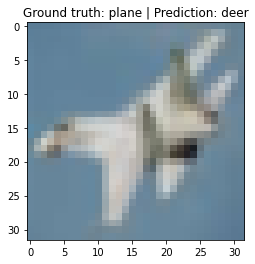

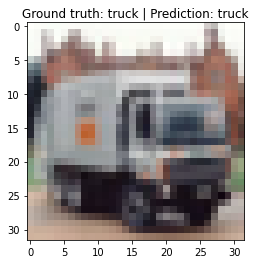

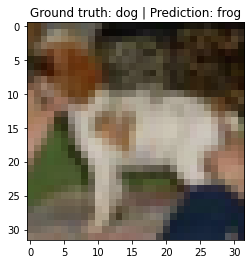

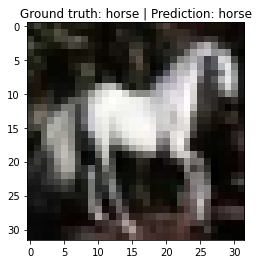

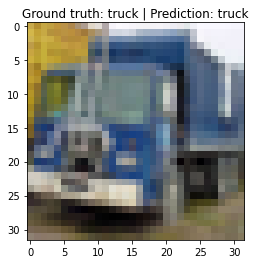

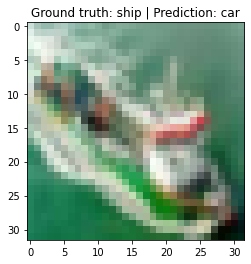

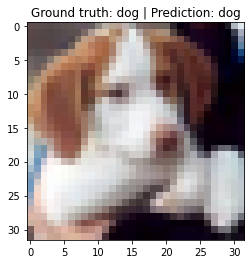

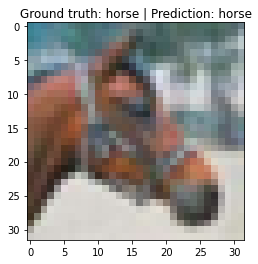

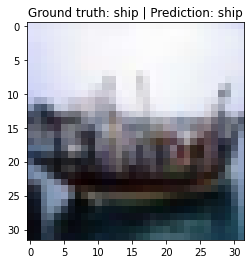

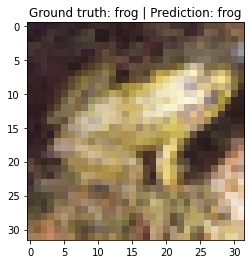

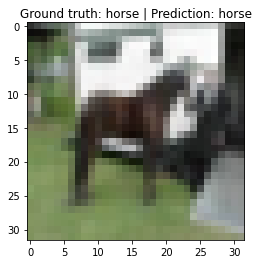

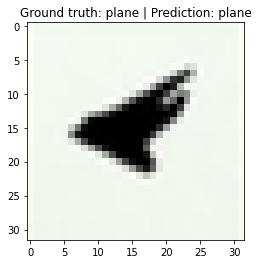

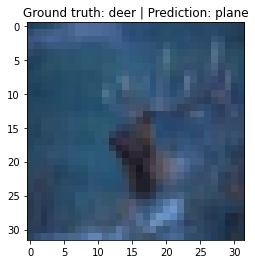

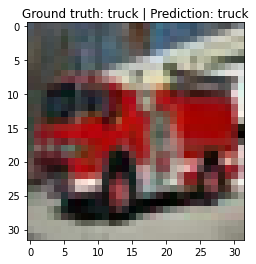

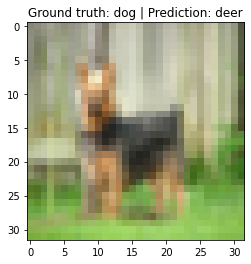

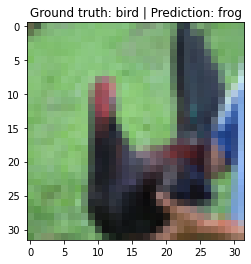

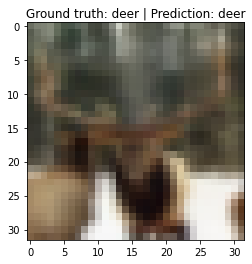

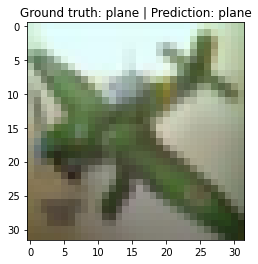

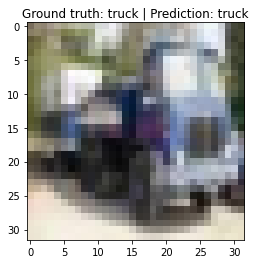

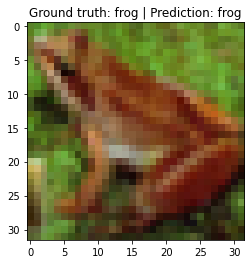

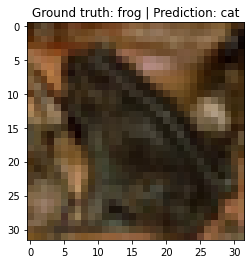

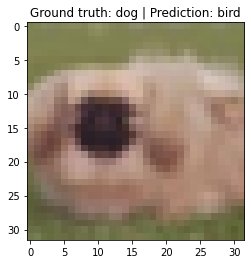

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

class_prob = model_wrapper.model(images.cuda()).cpu() #(32,10)

#print(class_prob)
#print(nn.Softmax(dim=1)(class_prob))

_, class_pred = torch.max(class_prob,1) # Dimension 1 to get the max from 10 classes

# print images
for j in range(32):
    imshow(torchvision.utils.make_grid(images[j]))
    plt.title('Ground truth: ' + str(classes[labels[j]]) + ' | Prediction: ' + str(classes[class_pred[j]]))
    plt.show()

Accuracy is not so good... Maybe it's because the model is not deep enough. Let's try deeper models, here a Resnet.

#ResNet as a backbone: a very deep network

ResNet [1] has been state-of-the-art in recent years and has only very recently been superseded (e.g. ResNeXt [2], EfficientNet [3]). ResNet is still commonly used because it is implemented, and easily accessible, in deep learning libraries, e.g. [4].

[1] He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

[2] Xie, Saining, et al. "Aggregated residual transformations for deep neural networks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.

[3] Tan, Mingxing, and Quoc V. Le. "Efficientnet: Rethinking model scaling for convolutional neural networks." arXiv preprint arXiv:1905.11946 (2019).

[4] https://pytorch.org/docs/stable/torchvision/models.html

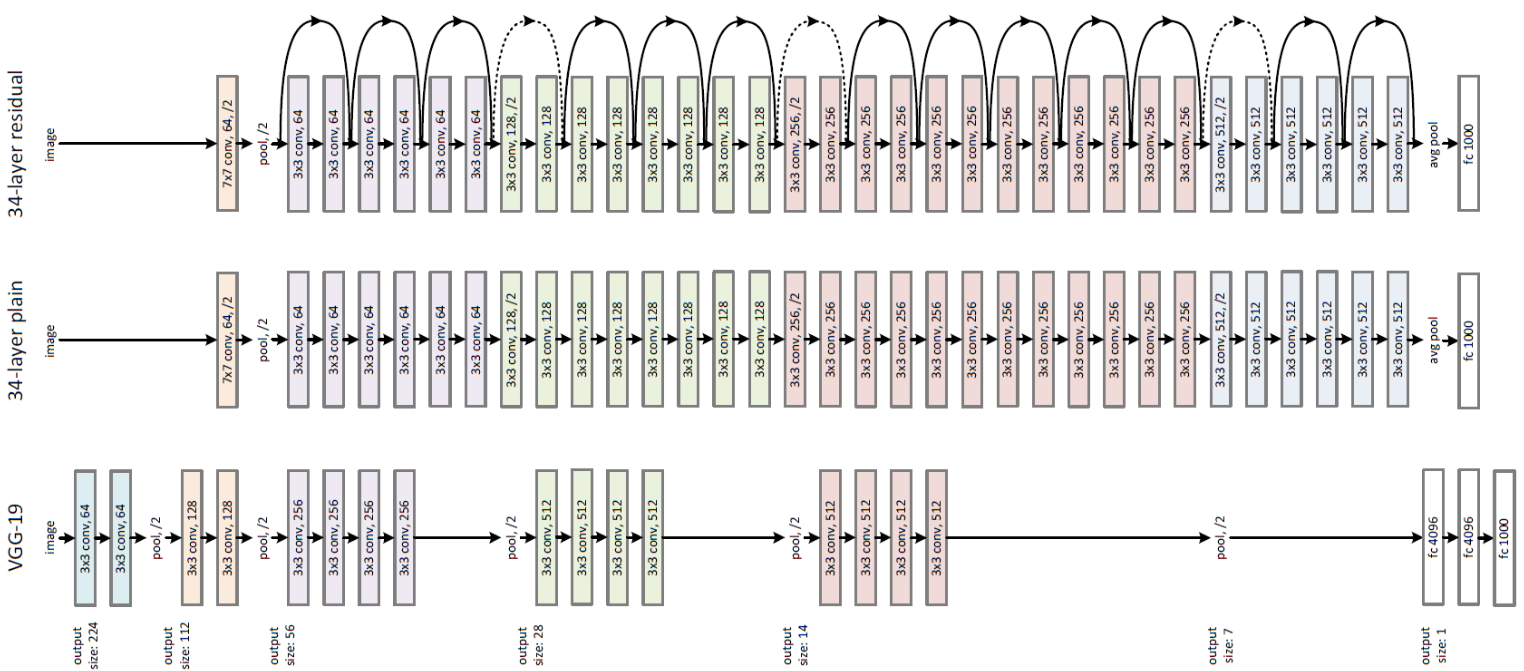

Roughly, ResNet (Residual Network) is based on residual blocks (see session 1, the power of depth for an introduction to residual blocks). Those residuals blocks are stacked for building four (deep) layers:

 image -> layer 1 (64) -> layer 2 (128) -> layer 3 (256) -> layer 4 (512)
 
 Each layer may contain many residual blocks. This choice defines the depth of ResNet. This is why it exists many ResNets with varying depth (ResNet34, ResNet50, ResNet101, ResNet152). Today we will work with ResNet50.

 It is straightforward to obtain a ResNet with pytorch.

In [10]:
from torchvision import models

resnet = models.resnet50()

Print the different layers of the network (.modules()). Why the last layer is Linear(in_features=2048, out_features=1000, bias=True)?

In [11]:
for module in resnet.modules(): # TODO
    print(module)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Learning weights from scratch
To use ResNet in the context of CIFAR10 (which is a 10 categories classification problem), we have to modify ResNet (the fully connected layers) in order to map to a 10 dimensions space (not 1000 dimensions space).

To do so, we build a ResNet as a pytorch module where the feature extractor is based on resnet.

In [13]:
class ResNet(nn.Module):
    def __init__(self, 
                 model_base,  # resnet backbone
                 class_num=10,  # 10 classes for CIFAR10
                 bottleneck_dim=256, # > 0 if use a bottleneck, 0 not use bottleneck
                 trainable_features=True # whether training the feature extractor
                 ):
        super(ResNet, self).__init__()

        self.trainable_features = trainable_features
        self.use_bottleneck = bottleneck_dim > 0
        
        # For colors, see the picture of resnet
        # Orange 
        self.conv1 = model_base.conv1
        self.bn1 = model_base.bn1
        self.relu = model_base.relu
        self.maxpool = model_base.maxpool

        # Purple
        self.layer1 = model_base.layer1
        
        # Green
        self.layer2 = model_base.layer2

        # Red 
        self.layer3 = model_base.layer3

        # Blue
        self.layer4 = model_base.layer4
        

        # Grey
        self.avgpool = model_base.avgpool

        # Feature extractor
        self.feature_layers = nn.Sequential(self.conv1, self.bn1, self.relu, self.maxpool, 
                                            self.layer1, self.layer2, self.layer3, self.layer4, 
                                            self.avgpool)
        

        # (Bottleneck) Classifier 
        if self.use_bottleneck:
            self.bottleneck = nn.Linear(model_base.fc.in_features, bottleneck_dim)
            self.fc = nn.Linear(bottleneck_dim, class_num)
            self.__in_features = bottleneck_dim
        else:
            self.fc = nn.Linear(model_base.fc.in_features, class_num)
            self.__in_features = model_base.fc.in_features

    def forward(self, x): # TODO
        features = self.feature_layers(x) # TODO
        features = features.view(features.size(0), -1)
        if self.use_bottleneck:
            features = self.bottleneck(features)
            features = F.relu(features)
        y = self.fc(features) # TODO
        return y

    def load_feature_layers(self, path):
        pass
        # TODO

    def load_bottleneck(self, path):
        pass 
        # TODO

    def get_parameters(self, feature_layers=True):
        return self.parameters()
        #TIPS: this is equivalent to:
        #parameter_list = [{"params": self.feature_layers.parameters()},
        #                          {"params": self.bottleneck.parameters()},
        #                          {"params": self.fc.parameters()}]
        #return parameter_list

In [14]:
resnet = models.resnet50()
resnet_cifar10 = ResNet(resnet) # TODO

model_wrapper = ModelWrapper(resnet_cifar10) # TODO
model_wrapper.compile(loss=nn.CrossEntropyLoss(), # TODO 
                      optimizer=torch.optim.Adam) # TODO
model_wrapper.train(trainset, epochs=3) # TODO. Start with 1,2,3 epochs to try

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [16]:
accuracy = model_wrapper.test(testset) #TODO
print('Accuracy is', accuracy)

Accuracy is 0.606499969959259


Using a deeper network has led to a substantial gain of accuracy. You can improve performances by increasing number of epochs but training may take a long time.

## Transfer of a pretrained feature extractor
We now use a ResNet pre-trained on ImageNet. From this pretrained feature extractor, we will fine-tune these representations on the specific task of CIFAR10 classificition. Pragmatically, pretrained representations will be used as weight initialization of the deep network.

key-words: fine-tuning and pre-training.

In [17]:
resnet_pretrained = models.resnet50(pretrained=True) # TODO, see documentation of torchvision.models
resnet_pretrained_cifar10 = ResNet(resnet_pretrained) # TODO

model_wrapper = ModelWrapper(resnet_pretrained_cifar10) # TODO
model_wrapper.compile(loss=nn.CrossEntropyLoss(), # TODO 
                      optimizer=torch.optim.Adam) # TODO
model_wrapper.train(trainset, epochs=5) # TODO

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
accuracy = model_wrapper.test(testset) #TODO
print('Accuracy is', accuracy)

Accuracy is 0.7544999718666077


Transfer of a pre-trained network on ImageNet allows to use powerful representations that can be used in the context of CIFAR10, a different task than ImageNet classification. This leads to an important gain of classification performance.

#Learning with few labelled samples
We take a few steps back to tackle more realistic applications (closer to the subjects you will have to deal with during your internship, for example).

Most of benchmarks used by the community exhibit, at some point, unrealistic situation: curated and well-annotated data, in a large number. Despite the fact that CIFAR10 is orders of magnitude away from Imagnet in terms of volume, we are still far from real applications where we have to learn complex tasks from little data (typically 1000 or hundreds). 

To reproduce this difficult scenario, we subsample a small subset of CIFAR10 training data (1%). Thus we build from the training set of CIFAR10 to datasets:
- labelled dataset (1% of training data)
- unlabelled dataset (99% of remaining training data)

We investigate the role of transfer learning / pretraining for tackling this realistic situation. Note that you will learn more about learning with few data in the session 7.

## Subsampling

In [ ]:
dataset_size = len(trainset)
print('Dataset size is', dataset_size)

Dataset size is 50000


In [ ]:
dataset_idx = list(range(dataset_size))
np.random.shuffle(dataset_idx)
print('Some random indices', dataset_idx[:10])

Some random indices [49591, 4317, 37369, 15290, 10399, 34958, 21405, 37658, 27097, 32267]


In [ ]:
# Split index
split_idx = int(np.floor(0.01 * dataset_size))

In [ ]:
labelled_idx, unlabelled_idx = dataset_idx[:split_idx], dataset_idx[split_idx:]

See this good blog post for understanding samplers and dataloaders https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a

In [ ]:
from torch.utils.data import SubsetRandomSampler

labelled_sampler = SubsetRandomSampler(labelled_idx) # TODO 
unlabelled_sampler = SubsetRandomSampler(unlabelled_idx) # TODO

Modify the method .train() of ModelWrapper in order to use a sampler in the dataloader.